# Pytorch object detection example

Пример использования [Single Shot Multibox Detector (SSD)](https://arxiv.org/abs/1512.02325), популярной, мощной и быстрой сети для задачи детектирования объектов. Оригинальную реализацию авторов можно найти [здесь](https://github.com/weiliu89/caffe/tree/ssd).

In [1]:
import numpy as np
import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tqdm.notebook import tqdm
import ffmpeg

In [2]:
# загрузим видео и перекодируем его в np.array
# уверен можно сделать и лучше, но для примера сойдет

filepath = './input/spb_1.MOV'

probe = ffmpeg.probe(filepath)
video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)
width = int(video_stream['width'])
height = int(video_stream['height'])
print(width, height)

out, _ = (
    ffmpeg
    .input(filepath)
    .output('pipe:', format='rawvideo', pix_fmt='rgb24')
    .run(capture_stdout=True)
)
video = (
    np
    .frombuffer(out, np.uint8)
    .reshape([-1, height,width, 3])[:, ::,::,:]
#     .reshape([-1,width, height, 3])[:, ::4,::4,:]
)

1440 1080


In [3]:
# функция для просмотра кадров
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))

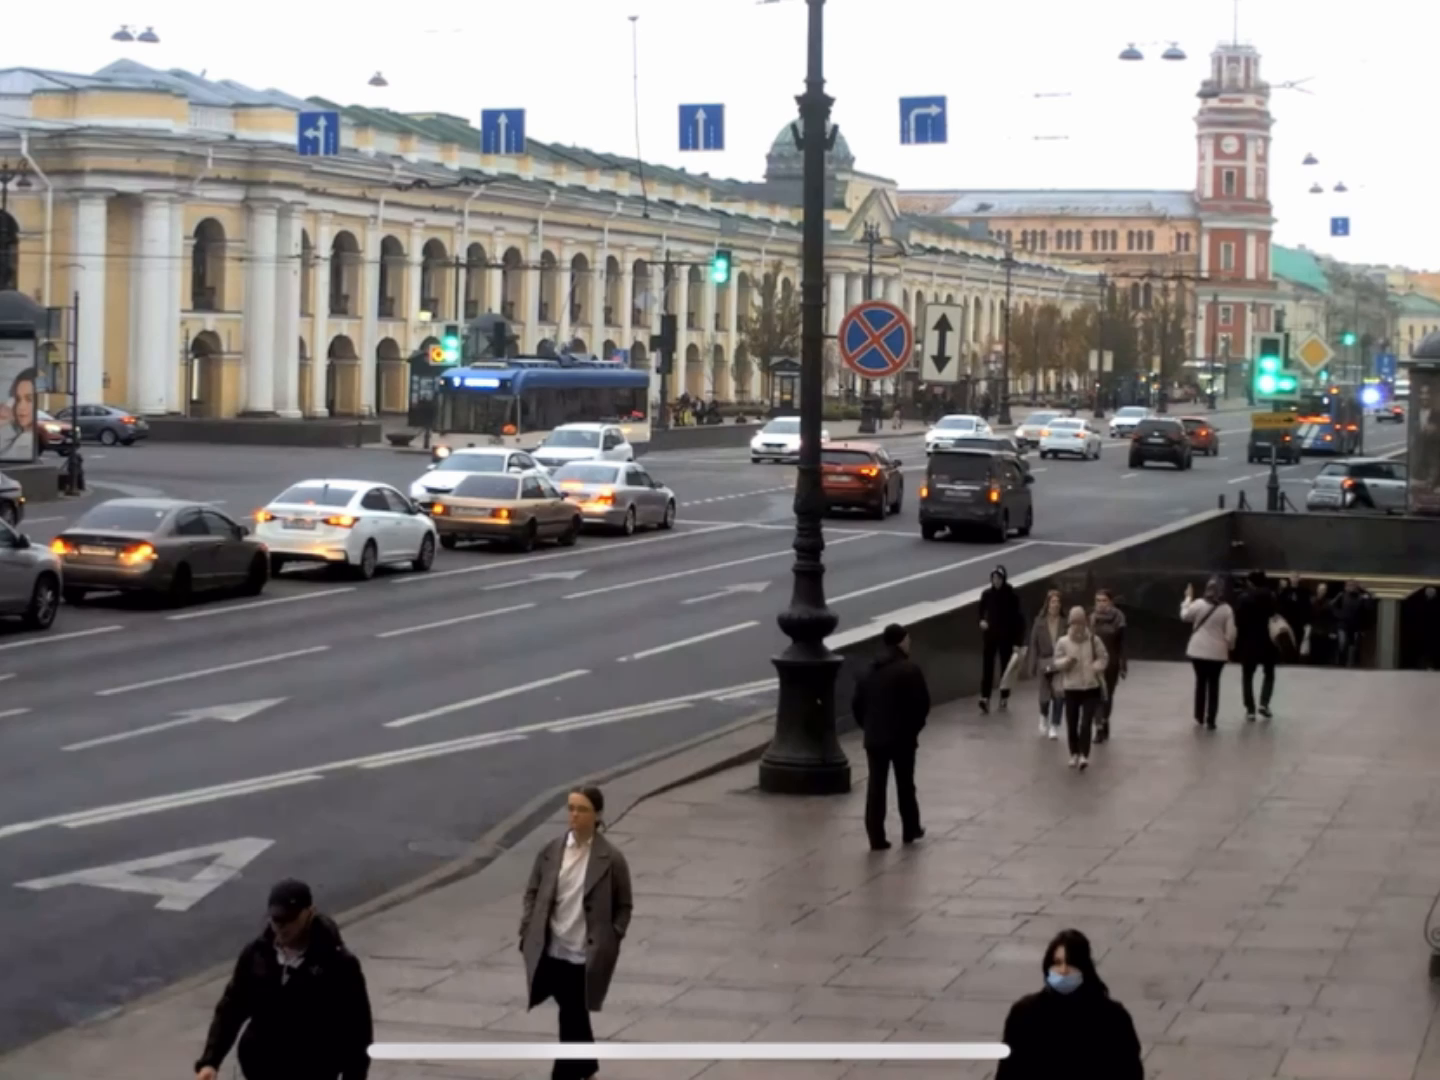

In [4]:
show(video[0])

In [5]:
from torchvision import transforms
from utils import *
from PIL import Image, ImageDraw, ImageFont

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# загрузим обученный чекпоинт
checkpoint = 'checkpoint_ssd300.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)
model.eval()

# Трансформации
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])



Loaded checkpoint from epoch 232.



/home/basil/mlenv/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'model.SSD300' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/basil/mlenv/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/basil/mlenv/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `t

In [12]:
def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Детекция объектов обученной SSD300, и визуализация результатов.

    :param original_image: картинка - PIL Image
    :param min_score: минимальный threshold для детекции
    :param max_overlap: максимальный скор для наложения, чтобы классы не перекрывались
    :param top_k: если классов в результате слишком много то сохраним топ 'k'
    :param suppress: классы, которые исключить из модели, если Вы уверены что их нет (list)
    :return: картингка с аннотациями PIL Image
    """

    # Трансформирумируем
    image = normalize(to_tensor(resize(original_image)))

    # Отправим на устройство (cuda/cpu)
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # непосредственно детекция
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # отправим на CPU
    det_boxes = det_boxes[0].to('cpu')

    # трансформируем к размеру картинки обратно
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # добавим лейблы
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # если объекты не найдены, добавляем лейбл ['0.'], то есть ['background'] из SSD300.detect_objects() 
    if det_labels == ['background']:
        # просто вернем оригинальную картинку
        return original_image

    # Аннотируем (не забудьте загрузить шрифт!)
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.truetype("./calibril.ttf", 15)

    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Текст
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
    return annotated_image

In [7]:
# теперь сделаем это для всех кадров
d_video = []
for frame in tqdm(video):
    d_frame = detect(PIL.Image.fromarray(frame), min_score=0.2, max_overlap=0.5, top_k=200)
    d_video.append(d_frame)

/home/basil/code/tiktok/pytorch_object_detection_tutorial/model.py:495: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  condition = torch.tensor(condition, dtype=torch.uint8).to(device)
/home/basil/code/tiktok/pytorch_object_detection_tutorial/model.py:505: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/home/basil/code/tiktok/pytorch_object_detection_tutorial/model.py:507: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
  image_scores.append(class_scores[1 - suppress])


In [8]:
d_video = np.array([np.array(f) for f in d_video])

In [9]:
# закодируем кадры обратно в видео
def vidwrite(fn, images, framerate=60, vcodec='libx264'):
    if not isinstance(images, np.ndarray):
        images = np.asarray(images)
    n,height,width,channels = images.shape
    process = (
        ffmpeg
            .input('pipe:', 
                   format='rawvideo', 
                   pix_fmt='rgb24', 
                   s='{}x{}'.format(width, height))
            .output(fn, pix_fmt='yuv420p', vcodec=vcodec, r=framerate)
            .overwrite_output()
            .run_async(pipe_stdin=True)
    )
    for frame in tqdm(images):
        process.stdin.write(
            frame
                .astype(np.uint8)
                .tobytes()
        )
    process.stdin.close()
    process.wait()

In [10]:
vidwrite('./input/out_spb_1.mp4', d_video)

Сделано на основе данного английского [урока](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection) 